In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# Ask for the folder path
folder_path = "../sketches"

IMG_SIZE = 256
IMAGES_PER_CLASS = 80
NUM_CLASSES = 15

def extract_edge_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    edges = cv2.Canny(img, 100, 200)
    return edges.flatten()

# Get the list of image files from subfolders
image_files = []
for class_folder in sorted(os.listdir(folder_path)):
    class_folder_path = os.path.join(folder_path, class_folder)
    if os.path.isdir(class_folder_path):
        class_images = sorted([os.path.join(class_folder, f) for f in os.listdir(class_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        assert len(class_images) == IMAGES_PER_CLASS, f"Expected {IMAGES_PER_CLASS} images in {class_folder}, found {len(class_images)}"
        image_files.extend(class_images)

assert len(image_files) == IMAGES_PER_CLASS * NUM_CLASSES, f"Expected {IMAGES_PER_CLASS * NUM_CLASSES} images, found {len(image_files)}"

features_list = []
labels_list = []

for idx, img_name in enumerate(tqdm(image_files, desc="Extracting features")):
    img_path = os.path.join(folder_path, img_name)
    features = extract_edge_features(img_path)
    label = idx // IMAGES_PER_CLASS  # Auto label
    features_list.append(features)
    labels_list.append(label)

# Combine labels with features
features_array = np.array(features_list)
labels_array = np.array(labels_list).reshape(-1, 1)
final_array = np.hstack((labels_array, features_array))

# Save to CSV and NumPy
np.save("edge_features.npy", final_array)

pd.DataFrame(final_array).to_csv("edge_features.csv", index=False, header=False)

print("✅ Feature extraction complete. Files saved as 'edge_features.npy' and 'edge_features.csv'.")


Extracting features:   1%|          | 9/1200 [00:00<00:14, 81.62it/s]

Extracting features: 100%|██████████| 1200/1200 [00:09<00:00, 125.63it/s]


✅ Feature extraction complete. Files saved as 'edge_features.npy' and 'edge_features.csv'.


In [ ]:
from pandas import read_csv

data = read_csv("edge_features.csv", header=None)
data.head()

,0,5760,5761,5762,5763,5764,5765,5766,5767,5768,...,59805,60022,60023,60024,60025,60026,60027,60028,60029,60030
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Remove columns where all values are zero
non_zero_data = data.loc[:, (data != 0).any(axis=0)]
non_zero_data.head()

,0,5760,5761,5762,5763,5764,5765,5766,5767,5768,...,59805,60022,60023,60024,60025,60026,60027,60028,60029,60030
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Load the feature vector from the .npy file
loaded_features = np.load("edge_features.npy")

# Print the feature vector
print(loaded_features)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [14  0  0 ...  0  0  0]
 [14  0  0 ...  0  0  0]
 [14  0  0 ...  0  0  0]]


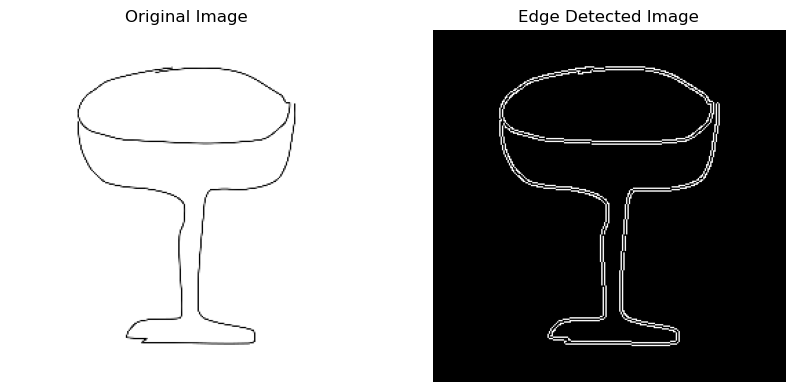

In [5]:
# Test the extract_edge_features function on a single image
test_image_path = os.path.join(folder_path, class_images[0])
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
test_image_resized = cv2.resize(test_image, (IMG_SIZE, IMG_SIZE))
test_edges = cv2.Canny(test_image_resized, 100, 200)

# Visualize the original and edge-detected images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(test_image_resized, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Edge Detected Image")
plt.imshow(test_edges, cmap='gray')
plt.axis('off')

plt.show()


In [10]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.feature import hog

folder_path = "../sketches"

IMG_SIZE = 256
IMAGES_PER_CLASS = 80
NUM_CLASSES = 15

# Function to extract HOG-based edge features
def extract_edge_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    features, _ = hog(img,
                      orientations=9,
                      pixels_per_cell=(16, 16),
                      cells_per_block=(2, 2),
                      block_norm='L2-Hys',
                      visualize=True)
    return features

# Get the list of image files from subfolders
image_files = []
for class_folder in sorted(os.listdir(folder_path)):
    class_folder_path = os.path.join(folder_path, class_folder)
    if os.path.isdir(class_folder_path):
        class_images = sorted([os.path.join(class_folder, f) for f in os.listdir(class_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        assert len(class_images) == IMAGES_PER_CLASS, f"Expected {IMAGES_PER_CLASS} images in {class_folder}, found {len(class_images)}"
        image_files.extend(class_images)

assert len(image_files) == IMAGES_PER_CLASS * NUM_CLASSES, f"Expected {IMAGES_PER_CLASS * NUM_CLASSES} images, found {len(image_files)}"

features_list = []
labels_list = []

for idx, img_name in enumerate(tqdm(image_files, desc="Extracting HOG features")):
    img_path = os.path.join(folder_path, img_name)
    features = extract_edge_features(img_path)
    label = idx // IMAGES_PER_CLASS  # Class label based on position
    features_list.append(features)
    labels_list.append(label)

# Combine label and features
df = pd.DataFrame(features_list)
df.insert(0, 'label', labels_list)

# Save to CSV
csv_path = "edge_hog_features.csv"
df.to_csv(csv_path, index=False)
print(f"\n Feature extraction complete. CSV saved as '{csv_path}'.")

# Print sample output
print("\n Sample extracted features:")
print(df.head())

Extracting HOG features: 100%|██████████| 1200/1200 [01:18<00:00, 15.28it/s]



 Feature extraction complete. CSV saved as 'edge_hog_features.csv'.

 Sample extracted features:
   label    0    1    2    3    4    5    6    7    8  ...  8090  8091  8092  \
0      0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1      0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2      0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3      0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4      0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

   8093  8094  8095  8096  8097  8098  8099  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 8101 columns]
